In [20]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import warnings


In [21]:
cc_train = pd.read_csv('/content/Edureka_Consumer_Complaints_train.csv', engine='python',encoding='utf-8',error_bad_lines=False)
cc_test = pd.read_csv('/content/Edureka_Consumer_Complaints_test.csv',engine='python',encoding='utf-8',error_bad_lines=False)

In [366]:
cc_train.isnull().sum()/cc_train.shape[0]*100

Date received                    0.000000
Product                          0.000000
Sub-product                     28.925058
Issue                            0.000000
Sub-issue                       61.139322
Consumer complaint narrative    84.342688
Company public response         81.067696
Company                          0.000000
State                            0.809063
ZIP code                         0.811293
Tags                            86.002062
Consumer consent provided?      71.689752
Submitted via                    0.000000
Date sent to company             0.000000
Company response to consumer     0.000000
Timely response?                 0.000000
Consumer disputed?               0.000000
Complaint ID                     0.000000
data                             0.000000
dtype: float64

In [88]:
cc_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358810 entries, 0 to 358809
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 358810 non-null  object
 1   Product                       358810 non-null  object
 2   Sub-product                   255024 non-null  object
 3   Issue                         358810 non-null  object
 4   Sub-issue                     139436 non-null  object
 5   Consumer complaint narrative  56180 non-null   object
 6   Company public response       67931 non-null   object
 7   Company                       358810 non-null  object
 8   State                         355907 non-null  object
 9   ZIP code                      355899 non-null  object
 10  Tags                          50226 non-null   object
 11  Consumer consent provided?    101580 non-null  object
 12  Submitted via                 358810 non-null  object
 13 

In [24]:
cc_train1 = cc_train[['Complaint ID','Date received','Product','Issue','Company','State','Submitted via','Company response to consumer','Timely response?','Consumer disputed?','Consumer complaint narrative']]

In [25]:
df1 = cc_train1[pd.notnull(cc_train['Consumer complaint narrative'])]

In [26]:
train_x, valid_x, train_y, valid_y = train_test_split(df1['Consumer complaint narrative'], df1['Product'],stratify=df1['Product'], 
                                                    test_size=0.25)

In [27]:
enc = preprocessing.LabelEncoder()
train_y = enc.fit_transform(train_y)
valid_y = enc.fit_transform(valid_y)

In [28]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df1['Consumer complaint narrative'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

In [30]:
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression()
lr_params = {'C':[int(x) for x in np.linspace(1,10,10)]}
grid_lr = GridSearchCV(estimator=clf,param_grid=lr_params,cv=5,n_jobs=-1)
grid_lr.fit(xtrain_tfidf,train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [31]:
print(grid_lr.best_params_)
print(grid_lr.best_score_)


{'C': 3}
0.8478699418535658


In [32]:
final_lr = LogisticRegression(C=3)
final_lr.fit(xtrain_tfidf,train_y)

LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
final_lr_predict = final_lr.predict(xvalid_tfidf)
lr_accuracy = metrics.accuracy_score(final_lr_predict, valid_y)
print ("Logistic Regression > Accuracy: ", lr_accuracy)

Logistic Regression > Accuracy:  0.8474902100391598


In [35]:
from sklearn.metrics import classification_report
print(classification_report(valid_y, final_lr_predict,target_names=df1['Product'].unique()))

                         precision    recall  f1-score   support

Bank account or service       0.81      0.79      0.80      1219
               Mortgage       0.76      0.64      0.69       776
        Debt collection       0.81      0.81      0.81      1665
          Consumer Loan       0.87      0.87      0.87      2667
            Credit card       0.82      0.88      0.85      3600
       Credit reporting       0.76      0.71      0.73       136
            Payday loan       0.92      0.95      0.93      3061
           Student loan       0.00      0.00      0.00        24
        Money transfers       0.69      0.32      0.43       151
           Prepaid card       0.81      0.63      0.71       152
Other financial service       0.89      0.81      0.84       593
       Virtual currency       0.00      0.00      0.00         1

               accuracy                           0.85     14045
              macro avg       0.68      0.62      0.64     14045
           weighted avg

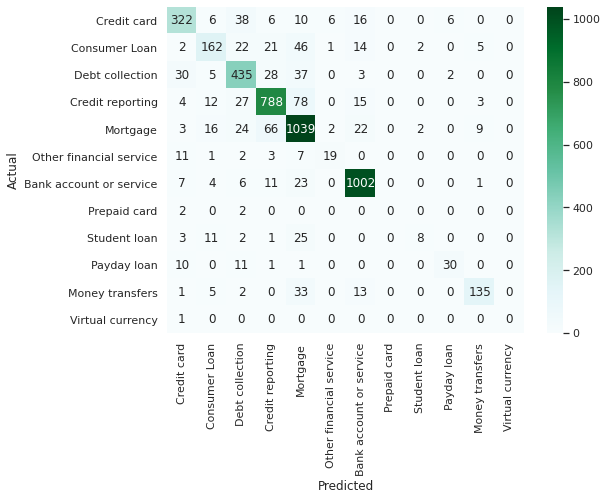

In [367]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(valid_y, final_lr_predict)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuGn",xticklabels=df1['Product'].unique(),yticklabels=df1['Product'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [363]:
print("shape of original dataset :",cc_train)
print("shape of input - training set", train_x.shape)
print("shape of output - training set", valid_x.shape)
print("shape of input - testing set", train_y.shape)
print("shape of output - testing set", valid_y.shape)

shape of original dataset :        Date received                  Product  ... Complaint ID   data
0         2015-10-14         Credit reporting  ...      1605653  train
1         2015-04-26  Bank account or service  ...      1347613  train
2         2013-12-20              Credit card  ...       640394  train
3         2016-03-03          Debt collection  ...      1815134  train
4         2015-01-30          Debt collection  ...      1218613  train
...              ...                      ...  ...          ...    ...
358805    2014-04-14         Credit reporting  ...       806868  train
358806    2013-03-14                 Mortgage  ...       355254  train
358807    2013-02-01              Credit card  ...       283994  train
358808    2015-06-25          Debt collection  ...      1438670  train
358809    2015-05-12         Credit reporting  ...      1372035  train

[358810 rows x 19 columns]
shape of input - training set (14185,)
shape of output - training set (4729,)
shape of input